# 0. Imports

In [1]:
# Imports
from IPython.display import display, HTML
import os
import h5py
import pandas as pd, datetime as dt, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import DateOffset
import sys

# Display options
thisnotebooksys = sys.stdout
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [2]:
import mimicLOB as lob
from mimicLOB.orderbook.orderbook import OrderBook
from mimicLOB.agent.replayerAgent import replayerAgent

## 1. LOB creation

In [3]:
# b_tape = True means the LOB 
LOB = OrderBook(tick_size  = 0.5, 
                b_tape     = True,
                b_tape_LOB = True,
                verbose    = True)

## 2. Data

- DTIME : le timestamp de l'ordre
- ORDER_ID : l'identifiant de l'ordre
- PRICE 
- QTY
- ORDER_SIDE
- ORDER_SIDE
- ORDER_TYPE :  <br>1 pour Market Order; <br>2 pour Limit Order; <br>q pour Quote <br> W pour Market On Open;
- ACTION_TYPE : <br> I = limit order insertion (passive); <br> C = limit order cacnellations; <br> R = replace order that lose priority; <br> r = replace order that keeps priority; <br> S = replace order that makes the order aggressive (give rise to trade); <br> T = aggressive order (give rise to trade)
- MATCH_STRATEGY : True/False
- IS_OPEN_TRADE :  True/False

In [46]:
df = pd.read_pickle(r'data\day20160428.pkl')
df

,DTIME,ORDER_ID,PRICE,QTY,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACTION_TYPE,MATCH_STRATEGY,IS_OPEN_TRADE
0,2016-04-28 06:04:00.002845,434884337166225159,4479.5,2,B,2,1,I,False,True
1,2016-04-28 06:04:00.002845,434884337166432696,4486.5,1,B,2,1,I,False,False
2,2016-04-28 06:04:00.002846,434884337165906933,4467.5,2,B,2,1,I,False,False
3,2016-04-28 06:04:00.002846,434884337166432748,4466.5,1,B,2,1,I,False,False
4,2016-04-28 06:04:00.002847,434884337160615272,4452.5,1,B,2,1,I,False,False
...,...,...,...,...,...,...,...,...,...,...
1656551,2016-04-28 21:15:00.624695,434884337166781043,4424.0,110,B,2,6,C,False,False
1656552,2016-04-28 21:15:00.624707,434884337166791567,4410.0,1,B,2,6,C,False,False
1656553,2016-04-28 21:15:00.624892,434884337166868579,4500.0,1,S,2,6,C,False,False
1656554,2016-04-28 21:15:00.624901,434884337166950905,4519.0,10,S,2,6,C,False,False


## 3. Agents Creation

In [5]:
auction_config = {'orderbook'        : LOB,
                  'id'               : 'Fayçal',
                  'b_record'         : False,
                  'historicalOrders' : df[df.DTIME.dt.hour<7]}

continuousTrading_config = {'orderbook'        : LOB,
                            'id'               : 'Fayçal',
                            'b_record'         : False,
                            'historicalOrders' : df[df.DTIME.dt.hour>=7]}

AuctionReplayer = replayerAgent(**auction_config)
ContReplayer    = replayerAgent(**continuousTrading_config)

## 4. Replay orders

### 4.1. Auction phase
#### The auction price shall be determined on the basis of the situation of the Central Order Book at the closing of the call phase and shall be the price which produces the highest executable order volume.

In [6]:
%%time

# log
f = open('log_auction.txt','w');
sys.stdout = f

# Close auction
LOB.b_auction = True #Open auction
AuctionReplayer.replayOrders()

# log
sys.stdout = thisnotebooksys

Wall time: 98.4 ms


### 4.2. Auction is over

Closing the auction will result in transactions and a new LOB with unmatched orders will be set.
The price is chosen as the one that maximizes volume of transactions.

Trades are executed at the auction price, and according to a time priority. The remaining orders at the auction price are the newest orders.

In [7]:
%%time

# log
f = open('log_auctionClose.txt','w');
sys.stdout = f

LOB.b_auction = False

# log
sys.stdout = thisnotebooksys

Wall time: 13.2 ms


### 4.3. Lob State
LOB state before opening the continuous trading

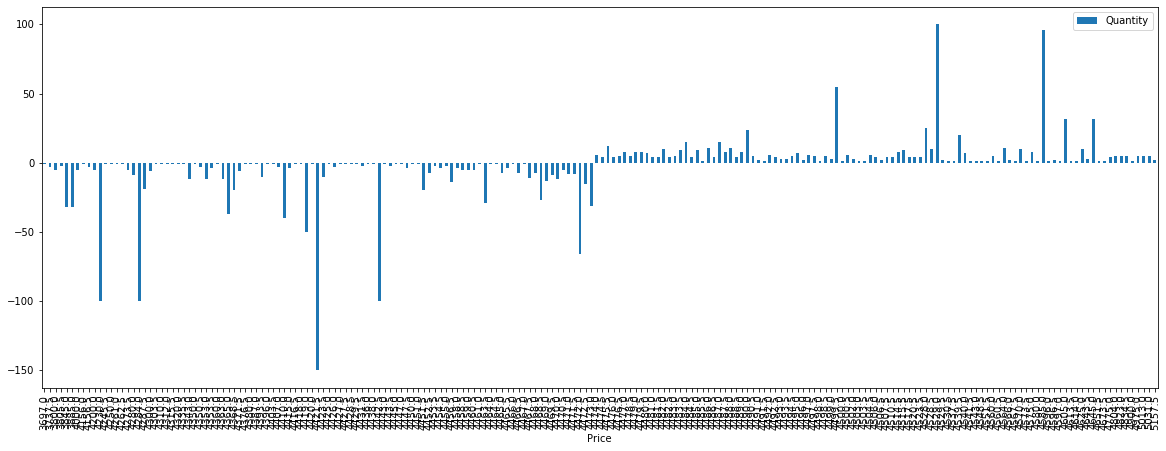

In [9]:
LOBstate = AuctionReplayer.getLOBState()
LOBstate = LOBstate.set_index('Price').sort_index()
LOBstate.plot.bar(figsize=(20, 7))
plt.show()

### 4.4. Continuous Trading

In [17]:
%%time

# log
f = open('log_continuousTrading.txt','w');
sys.stdout = f

# Close auction
ContReplayer.replayOrders()

# log
sys.stdout = thisnotebooksys

Wall time: 5min 37s


## 5. Price Tape

'open  : 4473.0'

'high  : 4500.5'

'low   : 4424.0'

'close : 4448.5'

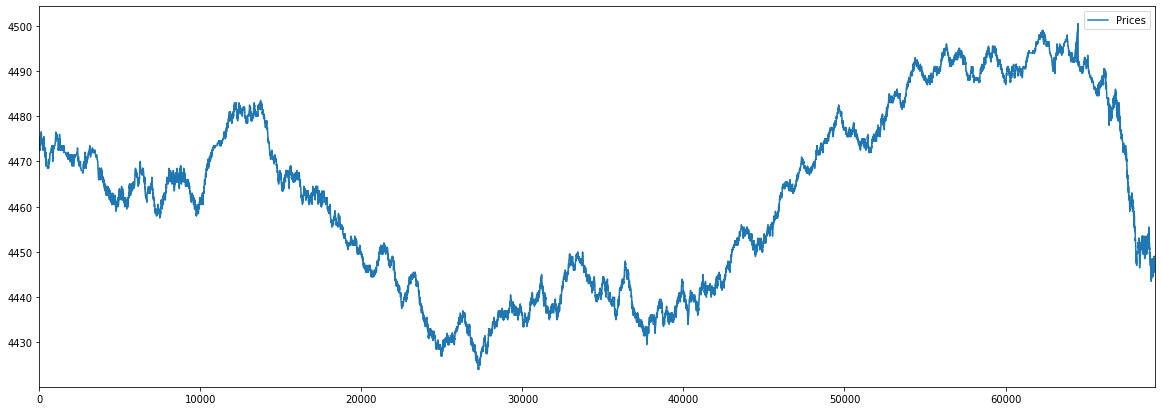

In [36]:
histoPrices = ContReplayer.getPriceTape().astype(float)
histoPrices.plot(figsize=(20,7))

# OHLC
display(f'open  : {histoPrices.iloc[0,0]}')
display(f'high  : {histoPrices.max()[0]}')
display(f'low   : {histoPrices.min()[0]}')
display(f'close : {histoPrices.iloc[-1, 0]}')

plt.show()

## Get Transaction Tape

In [34]:
TransactionTape = ContReplayer.getTransactionTape()

In [41]:
TransactionTape

,time,party1_id,party1_side,party1_order_id,party2_id,party2_side,party2_order_id,traded_price,traded_quantity
0,1587204506602972000,Fayçal,bid,434884337166225159,Fayçal,bid,434884337166435018,4473,2
1,1587204506602972000,Fayçal,bid,434884337166434900,Fayçal,bid,434884337166435018,4473,1
2,1587204506602972000,Fayçal,bid,434884337166434926,Fayçal,bid,434884337166435018,4473,1
3,1587204506602972000,Fayçal,bid,434884337166434945,Fayçal,bid,434884337166435018,4473,1
4,1587204506602972000,Fayçal,bid,434884337166434941,Fayçal,bid,434884337166435018,4473,4
...,...,...,...,...,...,...,...,...,...
69298,1587205261122384300,Fayçal,bid,434884337167472886,Fayçal,bid,434884337167472887,4447.5,2
69299,1587205261130362900,Fayçal,bid,434884337167472911,Fayçal,bid,434884337167472913,4448.5,1
69300,1587205261150317400,Fayçal,bid,434884337167472926,Fayçal,bid,434884337167472971,4448,1
69301,1587205261151362900,Fayçal,bid,434884337167472896,Fayçal,bid,434884337167472972,4447.5,1


## Get LOB Tape 

The LOB tape is the state of the LOB before each order arrival

In [38]:
LOBtape = AuctionReplayer.getLOBTape()

In [40]:
LOBtape

,TIME,ORDER_ID,PRICE,QTY,ORDER_SIDE,ORDER_TYPE,ACTION_TYPE,BID14,BID_QTY14,BID13,...,ASK10,ASK_QTY10,ASK11,ASK_QTY11,ASK12,ASK_QTY12,ASK13,ASK_QTY13,ASK14,ASK_QTY14
0,1587204505240547100,434884337166225159,4479.5,2,bid,limit,LO,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1587204505240547100,434884337166432696,4486.5,1,bid,limit,LO,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1587204505240547100,434884337165906933,4467.5,2,bid,limit,LO,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1587204505240547100,434884337166432748,4466.5,1,bid,limit,LO,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1587204505240547100,434884337160615272,4452.5,1,bid,limit,LO,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652039,1587205033050455200,434884337166781043,4424,110,bid,limit,cancel,4438.5,0,4439.0,...,4454.5,4,4455.0,5,4455.5,3,4456.0,0,4456.5,0
1652040,1587205036323287300,434884337166791567,4410,1,bid,limit,cancel,4438.5,0,4439.0,...,4454.5,4,4455.0,5,4455.5,3,4456.0,0,4456.5,0
1652041,None,434884337166868579,None,None,None,limit,cancel,4438.5,0,4439.0,...,4454.5,4,4455.0,5,4455.5,3,4456.0,0,4456.5,0
1652042,1587205089143303000,434884337166950905,4519,10,ask,limit,cancel,4438.5,0,4439.0,...,4454.5,4,4455.0,5,4455.5,3,4456.0,0,4456.5,0
